# **Projet Soutenance GOMYCODE** 
## 📅 *Mercredi*, **01/02/2023** - ***Casablanca Hacker Space***, *Maroc*
### 🧑 *Présenté par*  
##**AISSAMI Abdelhay**
###`Elève Data Scientist`

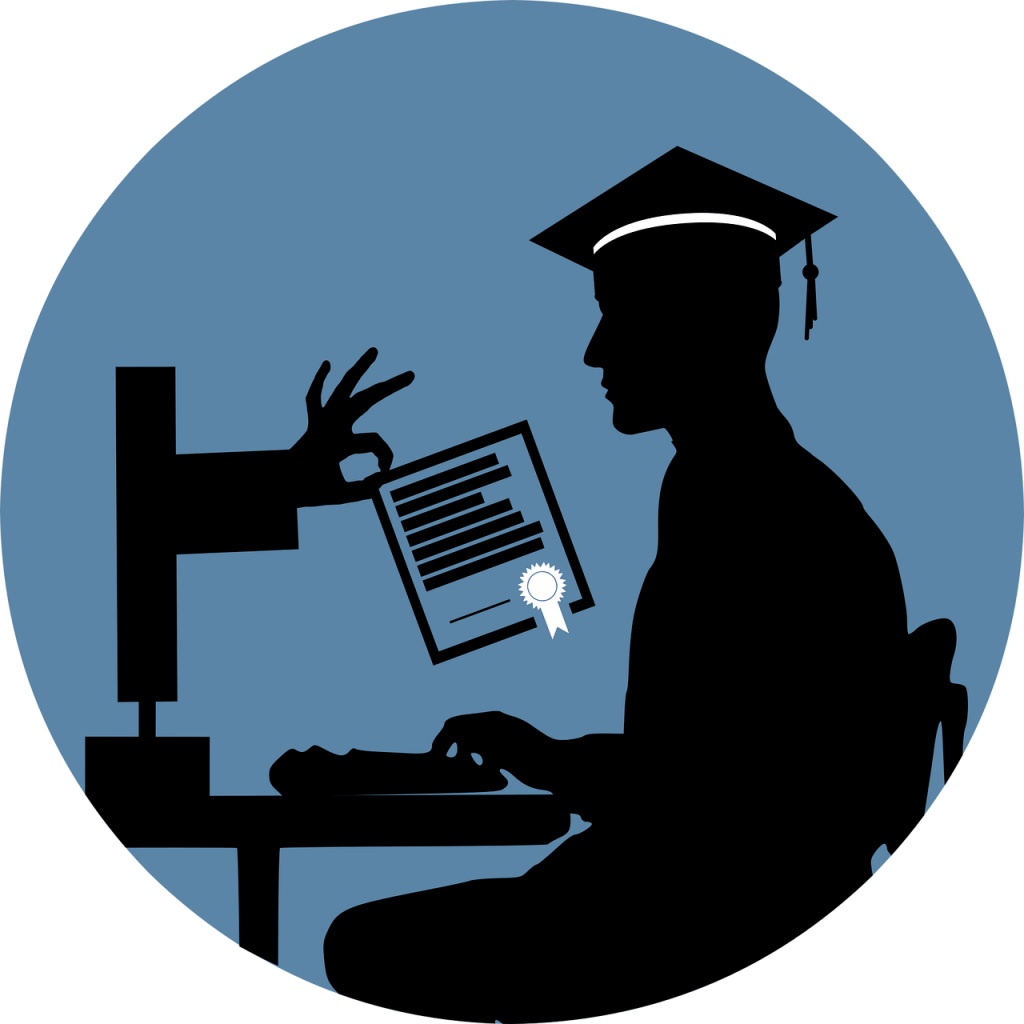


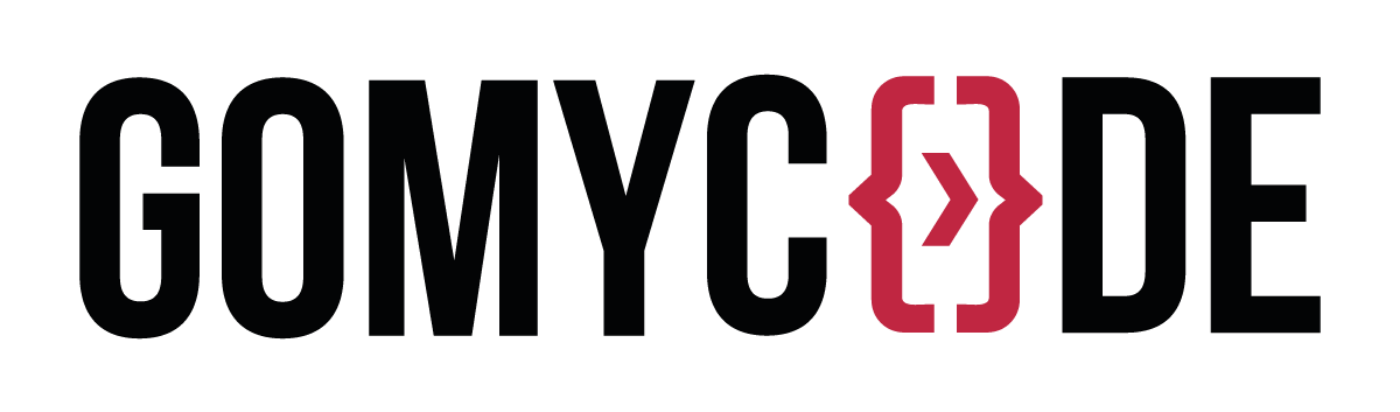

# **Projet De Fin D'étude**
## 🧑 *Instucteur*
###   **Yasser MATRANE**
## **Sujet** : TRADING ALGORITHMIQUE: Prédire les mouvements du marché des crypto monnaie

# INTRODUCTION


 « Le financement de Skynet est voté. Le système se met en place le 4 août 1997, la décision humaine est éliminée de la Défense Stratégique. Skynet commence à apprendre à vitesse géométrique. il devient autonome le 29 août 1997 à 2h14 du matin, heure de Greenwich ». Terminator 2, 1991.

Ces dernières années ont vu d'énormes progrès dans les domaines du machine learning "apprentissage automatique",le Deep Learning et l'intelligence artificielle. L'industrie financière en général et les traders du monde entier essaient également de bénéficier de ces technologies avances.

Ce projet présente des techniques issues des statistiques, comme la régression linéaire, et du
machine learning, comme la régression logistique, pour prédire les futurs mouvements de prix en fonction de retours passés. Il illustre également l'utilisation des réseaux de neurones pour prédire le mouvements du marché boursier . Bien entendu, ce projet ne peut remplacer une introduction approfondie au machine learning et au deep learning, mais il peut montrer, du point de vue d'un praticien, comment concrètement appliquer certaines techniques au problème de prévision des prix.

# Importation des librairies

In [234]:
import numpy as np
import datetime as dt
import pandas as pd
from cryptocmd import CmcScraper
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_regression

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor ,ExtraTreesRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
# Create smooth graph of close price data
from scipy.signal import savgol_filter
from math import sqrt
from prophet import Prophet
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import math

from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# web scraping et preprocessing

In [2]:

# initialise scraper
start = dt.date(2014, 12, 15).strftime("%d-%m-%Y")
end = dt.date.today().strftime("%d-%m-%Y")

crypto = ['BTC','ETH','BNB','XRP','SOL','LTC']
for coin in crypto:
    
    scraper = CmcScraper(coin, start, end)

    # # get data as list of list
    headers, data = scraper.get_data()

    # export the data to csv
    scraper.export_csv()
    name = coin+".csv"
    # get dataframe for the data
    scraper.get_dataframe().to_csv(name,index_label = False)

In [3]:
coins = dict(
bitcoin  =pd.read_csv("BTC.csv"),
ethereum = pd.read_csv("ETH.csv"),
ripple = pd.read_csv("XRP.csv"),
solana = pd.read_csv("SOL.csv"),
litecoin = pd.read_csv("LTC.csv")
)

for k,data in coins.items():
    data["slug"] = k
data= pd.concat(coins.values())

names = ['BTC','ETH','XRP', 'SOL','LTC']
coi =list( data["slug"].unique())
dc = {}
for n,c in zip(names,coi):
    dc[c]=n
data["symbol"] = data["slug"].replace(dc)

In [4]:
dataset=data[['slug','symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']]
dataset

,slug,symbol,Date,Open,High,Low,Close,Volume,Market Cap
0,bitcoin,BTC,2023-01-21,22677.427382,23282.347722,22511.833134,22777.625809,3.244228e+10,4.388967e+11
1,bitcoin,BTC,2023-01-20,21085.372338,22692.357831,20919.125984,22676.551759,2.879915e+10,4.369290e+11
2,bitcoin,BTC,2023-01-19,20686.745906,21163.012288,20685.381181,21086.793305,2.115285e+10,4.062799e+11
3,bitcoin,BTC,2023-01-18,21161.050900,21564.502213,20541.544549,20688.780730,3.000563e+10,3.985930e+11
4,bitcoin,BTC,2023-01-17,21175.833260,21438.659358,20978.533624,21161.519220,2.499998e+10,4.076820e+11
...,...,...,...,...,...,...,...,...,...
2955,litecoin,LTC,2014-12-19,2.805280,2.873840,2.727240,2.869110,2.780240e+06,1.000160e+08
2956,litecoin,LTC,2014-12-18,2.944430,2.995960,2.701970,2.805570,4.301260e+06,9.772292e+07
2957,litecoin,LTC,2014-12-17,3.010560,3.068830,2.899990,2.940230,3.969240e+06,1.023331e+08
2958,litecoin,LTC,2014-12-16,3.451840,3.460570,2.989270,3.015260,5.220210e+06,1.048602e+08


In [5]:
dataset.to_csv('cryptos.csv',index_label=False)

In [6]:
data = pd.read_csv('cryptos.csv')
data.index = data.Date
data.drop("Date",axis=1,inplace=True)

In [7]:
data.head()

,slug,symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,,
2023-01-21,bitcoin,BTC,22677.427382,23282.347722,22511.833134,22777.625809,3.244228e+10,4.388967e+11
2023-01-20,bitcoin,BTC,21085.372338,22692.357831,20919.125984,22676.551759,2.879915e+10,4.369290e+11
2023-01-19,bitcoin,BTC,20686.745906,21163.012288,20685.381181,21086.793305,2.115285e+10,4.062799e+11
2023-01-18,bitcoin,BTC,21161.050900,21564.502213,20541.544549,20688.780730,3.000563e+10,3.985930e+11
2023-01-17,bitcoin,BTC,21175.833260,21438.659358,20978.533624,21161.519220,2.499998e+10,4.076820e+11


In [8]:
name = data['slug'].unique()
print(name)

['bitcoin' 'ethereum' 'ripple' 'solana' 'litecoin']


    Open Le prix du coin au début de la journée de négociation.

    High : Le prix le plus élevé du coin un jour de bourse.

    Low : Le prix le plus bas du coin un jour de bourse.

    Close : Le dernier prix du coin avant la fin de la journée de négociation.

In [9]:
data = data[data.symbol.isin(['BTC','ETH','XRP', 'SOL','LTC' ])]

In [10]:
data.slug.value_counts()

bitcoin     2960
ripple      2960
litecoin    2960
ethereum    2725
solana      1017
Name: slug, dtype: int64

In [11]:
print(data.isnull().sum())

slug          0
symbol        0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64


In [12]:
print(data.duplicated().sum())

0


# Visualisation

2017 a été une année décisive pour les cryptomonnaies. Si on a surtout entendu parler de l'envolée spectaculaire du bitcoin qui a vu son cours se multiplier par 15, d'autres cryptomonnaies sont passées plus inaperçues. C'est le cas de la devise Ripple qui a pourtant gagné plus de 36 000 % depuis janvier 2017, comme le met en avant notre graphique.
Fin décembre 2017, on comptait un total de 1 335 monnaies numériques différentes pour une capitalisation boursière atteignant 572 milliards de dollars. À titre de comparaison : en 2016, il existait 644 cryptomonnaies différentes pour une valeur totale de 16,1 milliards de dollars.
Mais avec l'augmentation du cours des cryptomonnaies, le nombre de personnes qui minent ces devises numériques a également fortement grimpé, provoquant une hausse importante de la consommation d'électricité : 29 térawattheures d'électricité auraient en effet été consommées en 2017.

C'est quoi le market cap ?

"Market capitalization (ou market cap en abrégé, MCAP) se traduit par capitalisation boursière. Cela représente la valeur totale des actions en circulation d'une entreprise cotée. Pour l'obtenir, on multiplie le nombre de ces actions par le prix du jour de chacune d'entre elles.

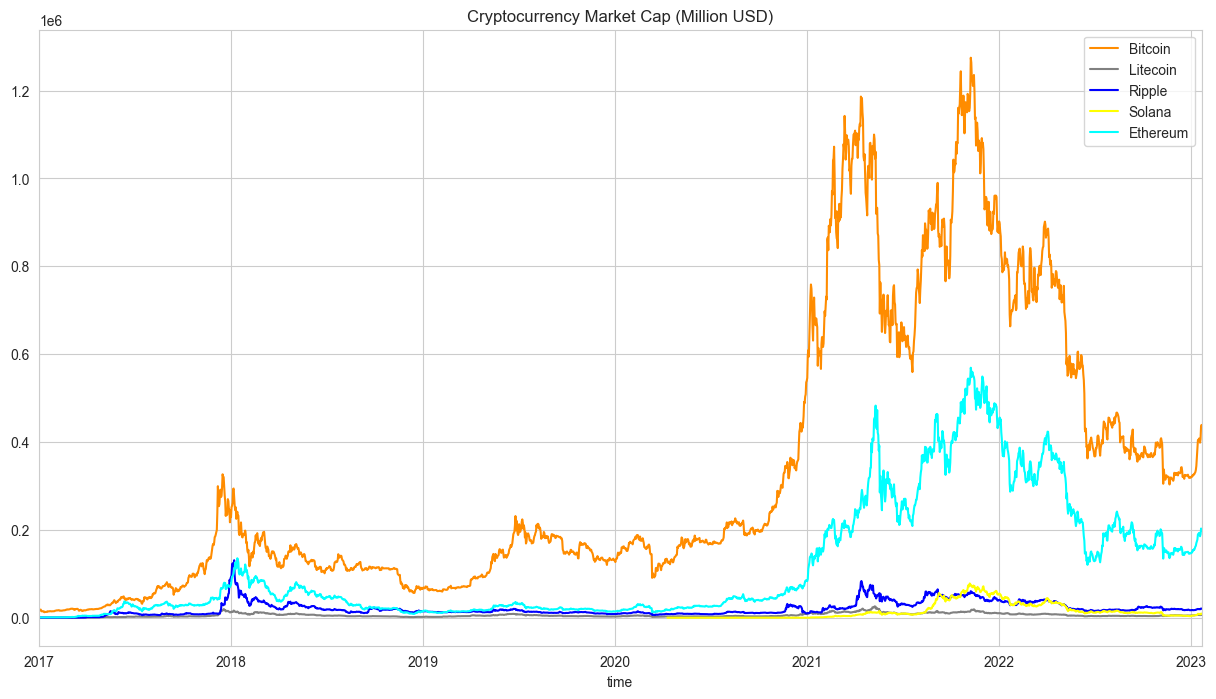

In [222]:
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
solana = data[data['symbol']=='SOL']
ethereum = data[data['symbol']=='ETH']

plt.figure(figsize=(15,8))
(bitcoin['Market Cap']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['Market Cap']/1000000).plot(color='grey', label='Litecoin')
(ripple['Market Cap']/1000000).plot(color='blue', label='Ripple')
(solana['Market Cap']/1000000).plot(color='yellow', label='Solana')
(ethereum['Market Cap']/1000000).plot(color='cyan', label='Ethereum')


plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Market Cap (Million USD)')
plt.show()

C'est quoi le volume dans le trading ?

Nombre de titres échangés au cours d'une séance de Bourse ou d'une transaction. 

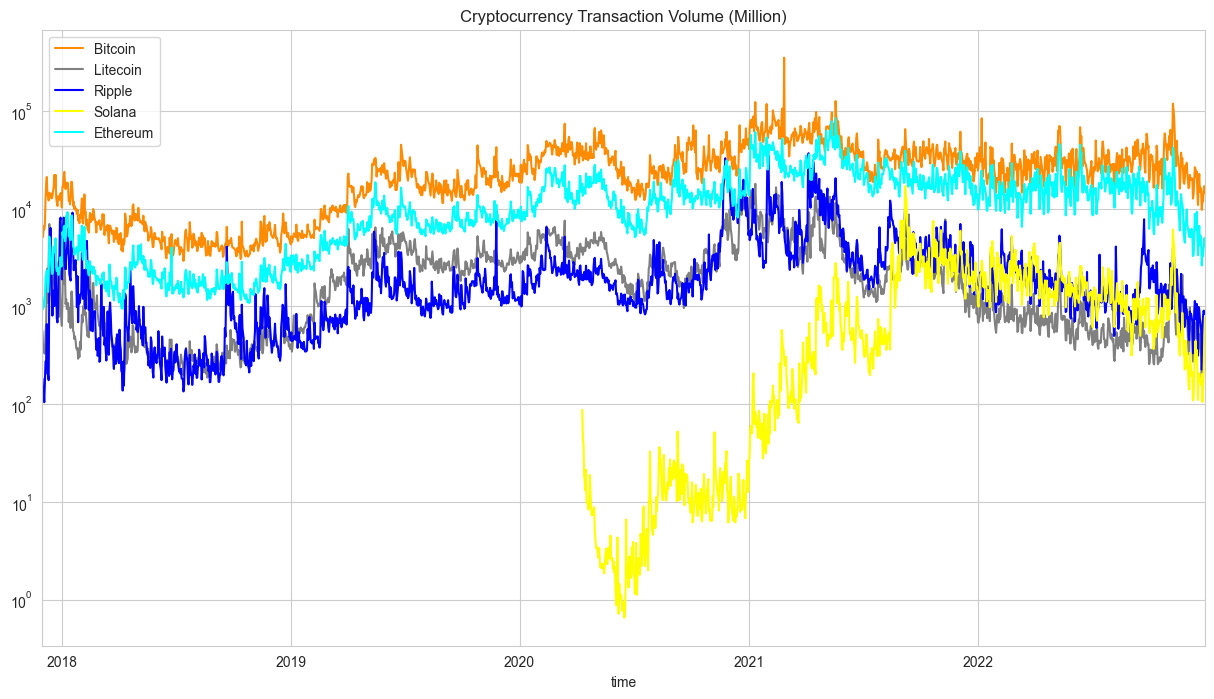

In [127]:
# plot transaction volume
plt.figure(figsize=(15,8))
(bitcoin['Volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['Volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['Volume']/1000000).plot(color='blue', label='Ripple')
(solana['Volume']/1000000).plot(color='yellow', label='Solana')
(ethereum['Volume']/1000000).plot(color='cyan', label='Ethereum')


plt.legend()
plt.xlabel('time')
plt.yscale('log')
plt.title('Cryptocurrency Transaction Volume (Million)')
plt.show()

    Comme nous pouvons le voir à la fois sur la capitalisation boursière et sur les graphiques du volume des transactions, rien ne s'est vraiment passé avant 2017 (Seul Bitcoin a effectué quelques transactions), 2017 a apparemment été une année décisive pour l'écosystème de la crypto-monnaie.

    On retrouve aussi :

    A mesure que le volume de transactions de BitCoin augmentait, le volume des autres crypto-monnaies augmentait également.

    Il semble que BitCoin mène les changements du marché.


In [15]:

data.index=[dt.datetime.strptime(
    i, '%Y-%m-%d') for i in data.index]

In [16]:
data_m = data['2017-12-01':'2022-12-29']

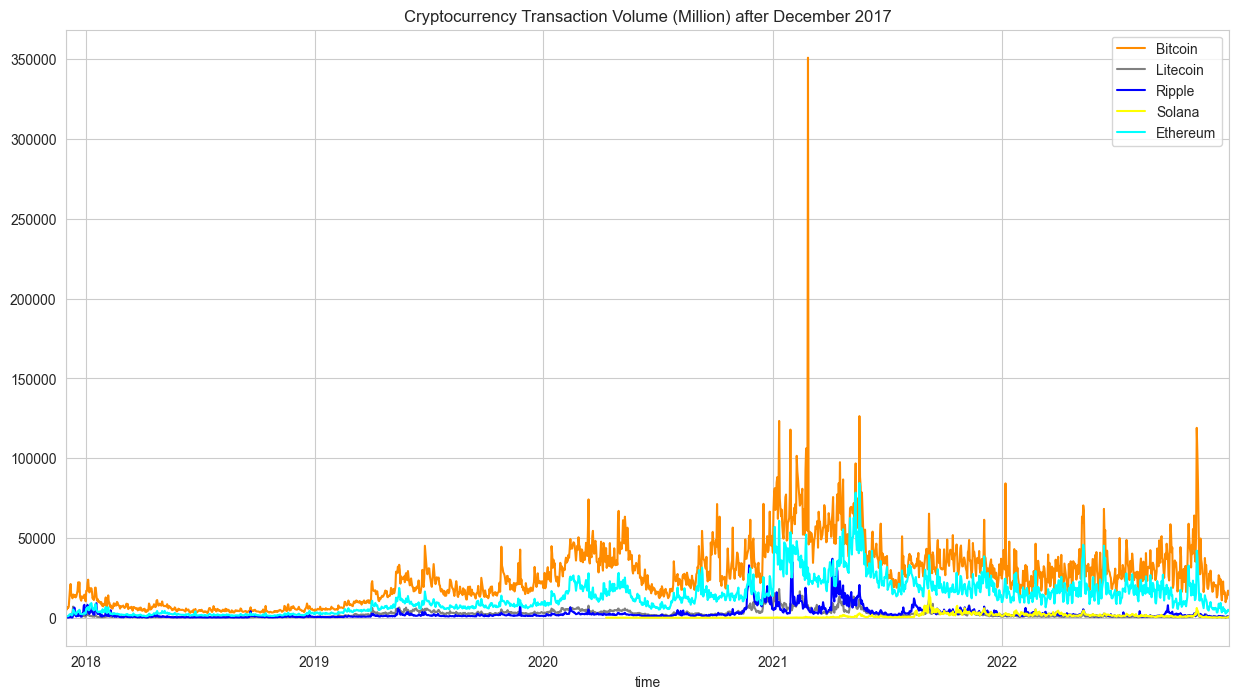

In [126]:
bitcoin = data_m[data_m['symbol']=='BTC']
litecoin = data_m[data_m['symbol']=='LTC']
ripple = data_m[data_m['symbol']=='XRP']
solana = data_m[data_m['symbol']=='SOL']
ethereum = data_m[data_m['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['Volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['Volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['Volume']/1000000).plot(color='blue', label='Ripple')
(solana['Volume']/1000000).plot(color='yellow', label='Solana')
(ethereum['Volume']/1000000).plot(color='cyan', label='Ethereum')


plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million) after December 2017')
plt.show()

In [18]:
data = data['2017-01-01':]
data.head()

,slug,symbol,Open,High,Low,Close,Volume,Market Cap
2023-01-21,bitcoin,BTC,22677.427382,23282.347722,22511.833134,22777.625809,3.244228e+10,4.388967e+11
2023-01-20,bitcoin,BTC,21085.372338,22692.357831,20919.125984,22676.551759,2.879915e+10,4.369290e+11
2023-01-19,bitcoin,BTC,20686.745906,21163.012288,20685.381181,21086.793305,2.115285e+10,4.062799e+11
2023-01-18,bitcoin,BTC,21161.050900,21564.502213,20541.544549,20688.780730,3.000563e+10,3.985930e+11
2023-01-17,bitcoin,BTC,21175.833260,21438.659358,20978.533624,21161.519220,2.499998e+10,4.076820e+11


#Fluctuation des prix des crypto-monnaies 

#Vérifiez l'ouverture, la clôture, le prix le plus élevé et le plus bas pour chacune des crypto-monnaies.

In [19]:
data['oc_diff']=data['Close']-data['Open']
data.head()

,slug,symbol,Open,High,Low,Close,Volume,Market Cap,oc_diff
2023-01-21,bitcoin,BTC,22677.427382,23282.347722,22511.833134,22777.625809,3.244228e+10,4.388967e+11,100.198427
2023-01-20,bitcoin,BTC,21085.372338,22692.357831,20919.125984,22676.551759,2.879915e+10,4.369290e+11,1591.179421
2023-01-19,bitcoin,BTC,20686.745906,21163.012288,20685.381181,21086.793305,2.115285e+10,4.062799e+11,400.047399
2023-01-18,bitcoin,BTC,21161.050900,21564.502213,20541.544549,20688.780730,3.000563e+10,3.985930e+11,-472.270170
2023-01-17,bitcoin,BTC,21175.833260,21438.659358,20978.533624,21161.519220,2.499998e+10,4.076820e+11,-14.314040


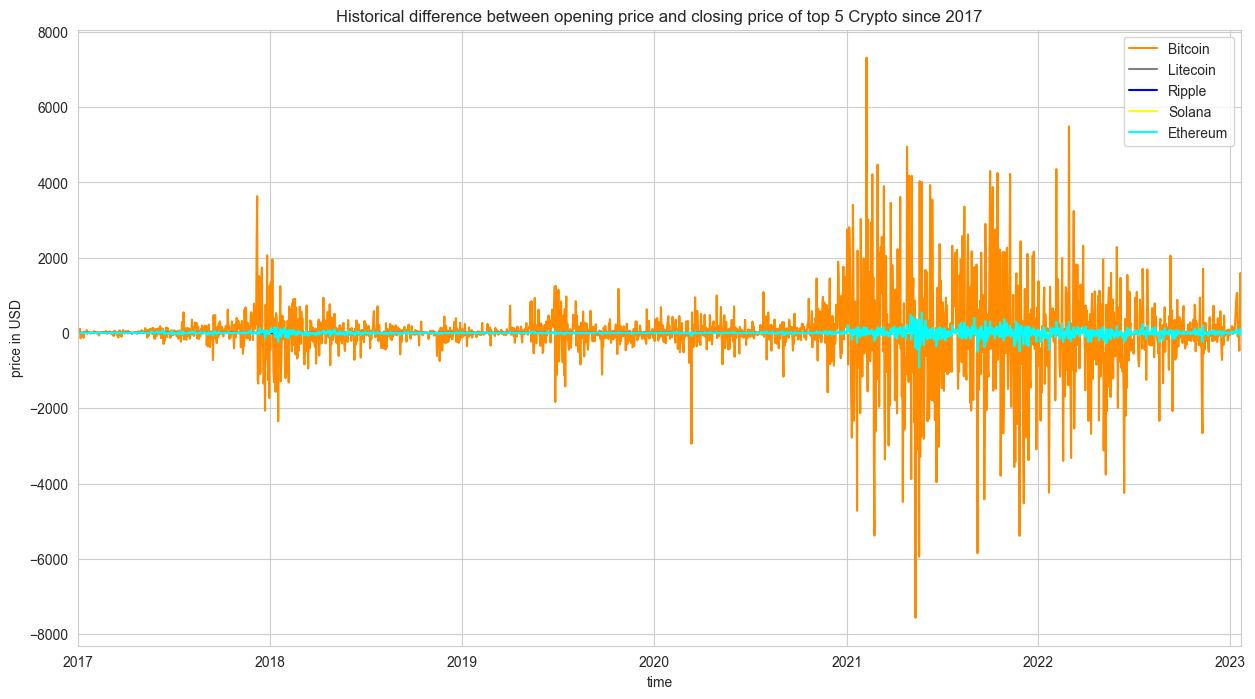

In [20]:
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
solana = data[data['symbol']=='SOL']
ethereum = data[data['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['oc_diff']).plot(color='darkorange', label='Bitcoin')
(litecoin['oc_diff']).plot(color='grey', label='Litecoin')
(ripple['oc_diff']).plot(color='blue', label='Ripple')
(solana['oc_diff']).plot(color='yellow', label='Solana')
(ethereum['oc_diff']).plot(color='cyan', label='Ethereum')


plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical difference between opening price and closing price of top 5 Crypto since 2017')
plt.legend()
plt.show()

    En traçant la différence entre le cours d'ouverture et le cours de clôture quotidiens, nous avons constaté que :

       Le cours d'ouverture et le cours de clôture quotidiens de BitCoin et d'Etherium varient le plus, les différences peuvent aller de 1000 à plus de 3000 dollars.
    Le reste des crypto-monnaies que nous avons sélectionnées a tendance à être assez stable

In [21]:
# Average difference for each cryptocurrency
ave_diff={'bitcoin':[(bitcoin['oc_diff']).mean()],
          'litecoin':[(litecoin['oc_diff']).mean()],
          'ripple':[(ripple['oc_diff']).mean()],
          'solana':[(solana['oc_diff']).mean()],
          'ethereum':[(ethereum['oc_diff']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bitcoin,litecoin,ripple,solana,ethereum
avg.diff,7.813758,0.012866,0.000185,-0.003094,0.522374


            Pour mieux comprendre la différence entre le cours d'ouverture et le cours de clôture quotidiens, nous avons calculé la différence moyenne

In [22]:
btc = bitcoin[['Close']]
btc.columns = ['BTC']
print(btc.head(10))
btc_ma=btc.rolling(window=5).mean()
print(btc_ma.head(10))
ltc = litecoin[['Close']]
ltc.columns = ['LTC']
ltc_ma=ltc.rolling(window=5).mean()

xrp = ripple[['Close']]
xrp.columns = ['XRP']
xrp_ma=xrp.rolling(window=5).mean()

sol = solana[['Close']]
sol.columns = ['SOL']
sol_ma=sol.rolling(window=5).mean()

eth = ethereum[['Close']]
eth.columns = ['ETH']
eth_ma=eth.rolling(window=5).mean()



# create matrix of close price only for later use
Close = pd.concat([btc,ltc,xrp,sol,eth], axis=1)
Close_ma = pd.concat([btc_ma,ltc_ma,xrp_ma,sol_ma,eth_ma], axis=1)
Close_ma.tail()

                     BTC
2023-01-21  22777.625809
2023-01-20  22676.551759
2023-01-19  21086.793305
2023-01-18  20688.780730
2023-01-17  21161.519220
2023-01-16  21169.632781
2023-01-15  20880.799202
2023-01-14  20976.299796
2023-01-13  19909.574625
2023-01-12  18869.588055
                     BTC
2023-01-21           NaN
2023-01-20           NaN
2023-01-19           NaN
2023-01-18           NaN
2023-01-17  21678.254165
2023-01-16  21356.655559
2023-01-15  20997.505048
2023-01-14  20975.406346
2023-01-13  20819.565125
2023-01-12  20361.178892


,BTC,LTC,XRP,SOL,ETH
2023-01-17,21678.254165,86.586581,0.395565,23.067515,1584.55639
2023-01-18,NaN,NaN,NaN,NaN,NaN
2023-01-19,NaN,NaN,NaN,NaN,NaN
2023-01-20,NaN,NaN,NaN,NaN,NaN
2023-01-21,NaN,NaN,NaN,NaN,NaN


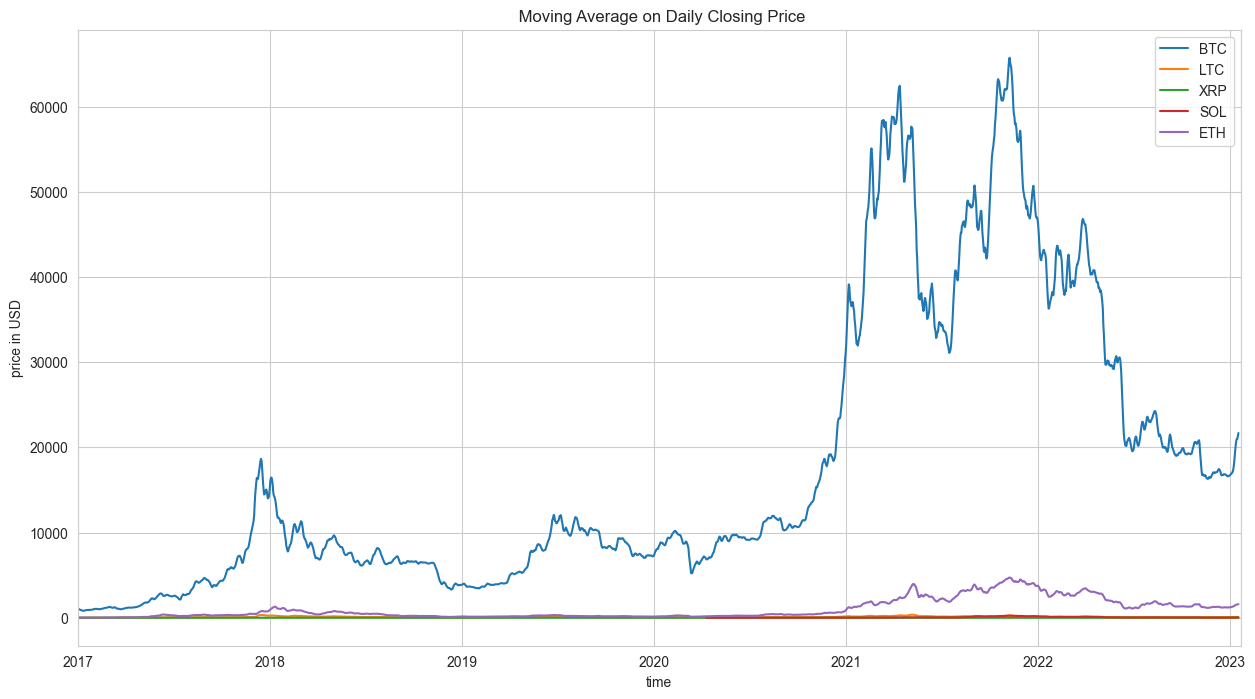

In [223]:
# plot moving average for closing price for cryptocurrencies
Close_ma.plot(figsize=(15,8))
plt.title(' Moving Average on Daily Closing Price')
plt.xlabel('time')
plt.ylabel('price in USD')
plt.show()

    Les prix du BitCoin et de l'Etherium fluctuent un peu plus que le reste des crypto-monnaies

    À partir de janvier 2018, il semble que le prix de BitCoin ait considérablement baissé mais a commencé à remonter vers 2021.

        Le Bitcoin a chutté a partir du mois de décembre 2021 Cependant, il est difficile de dire si BitCoin reviendra à son apogée.

In [24]:
data[data["symbol"]=="BTC"]["High"].max()

68789.62593892214

In [25]:
def getMax(coin):
    info = data[data["symbol"]==coin]["High"].values.max()
    return info,data.loc[data['High'].isin([info])].index
getMax("BTC")

(68789.62593892214,
 DatetimeIndex(['2021-11-10'], dtype='datetime64[ns]', freq=None))

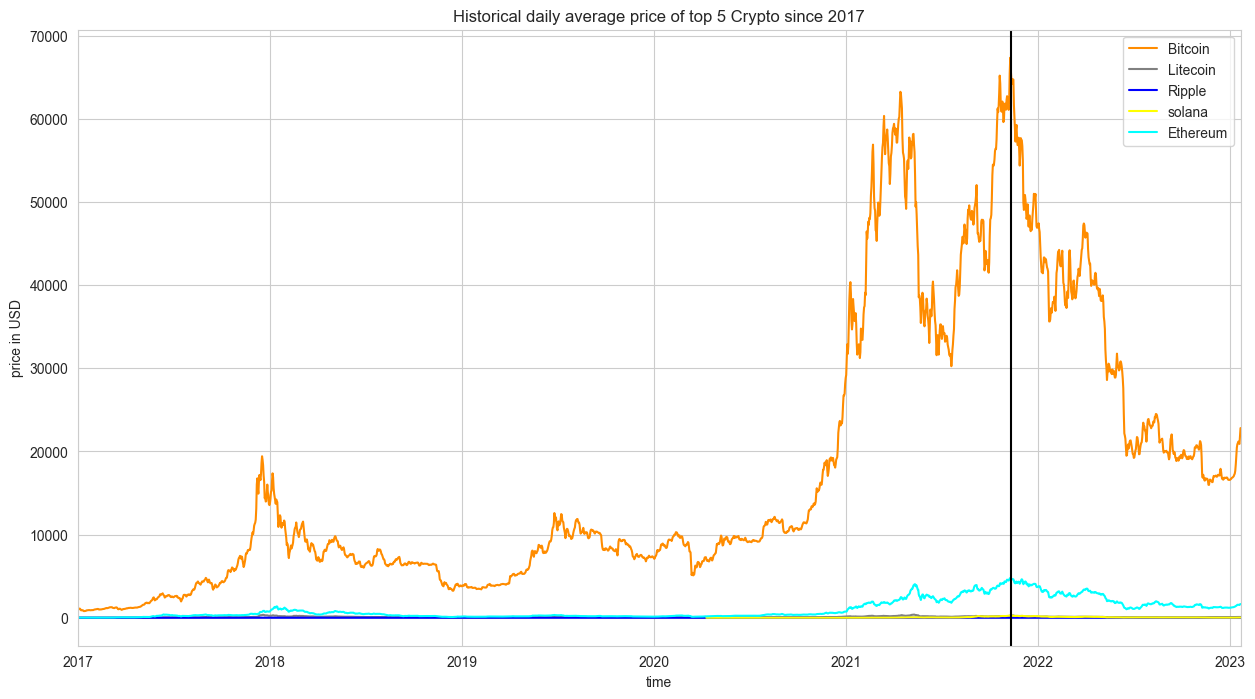

In [224]:
# calculate daily average price
data['daily_avg'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
solana = data[data['symbol']=='SOL']
ethereum = data[data['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['daily_avg']).plot(color='darkorange', label='Bitcoin')
(litecoin['daily_avg']).plot(color='grey', label='Litecoin')
(ripple['daily_avg']).plot(color='blue', label='Ripple')
(solana['daily_avg']).plot(color='yellow', label='solana')
(ethereum['daily_avg']).plot(color='cyan', label='Ethereum')

plt.axvline(dt.datetime(2021, 11, 10),color='black')
plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical daily average price of top 5 Crypto since 2017')
plt.legend()
plt.show()

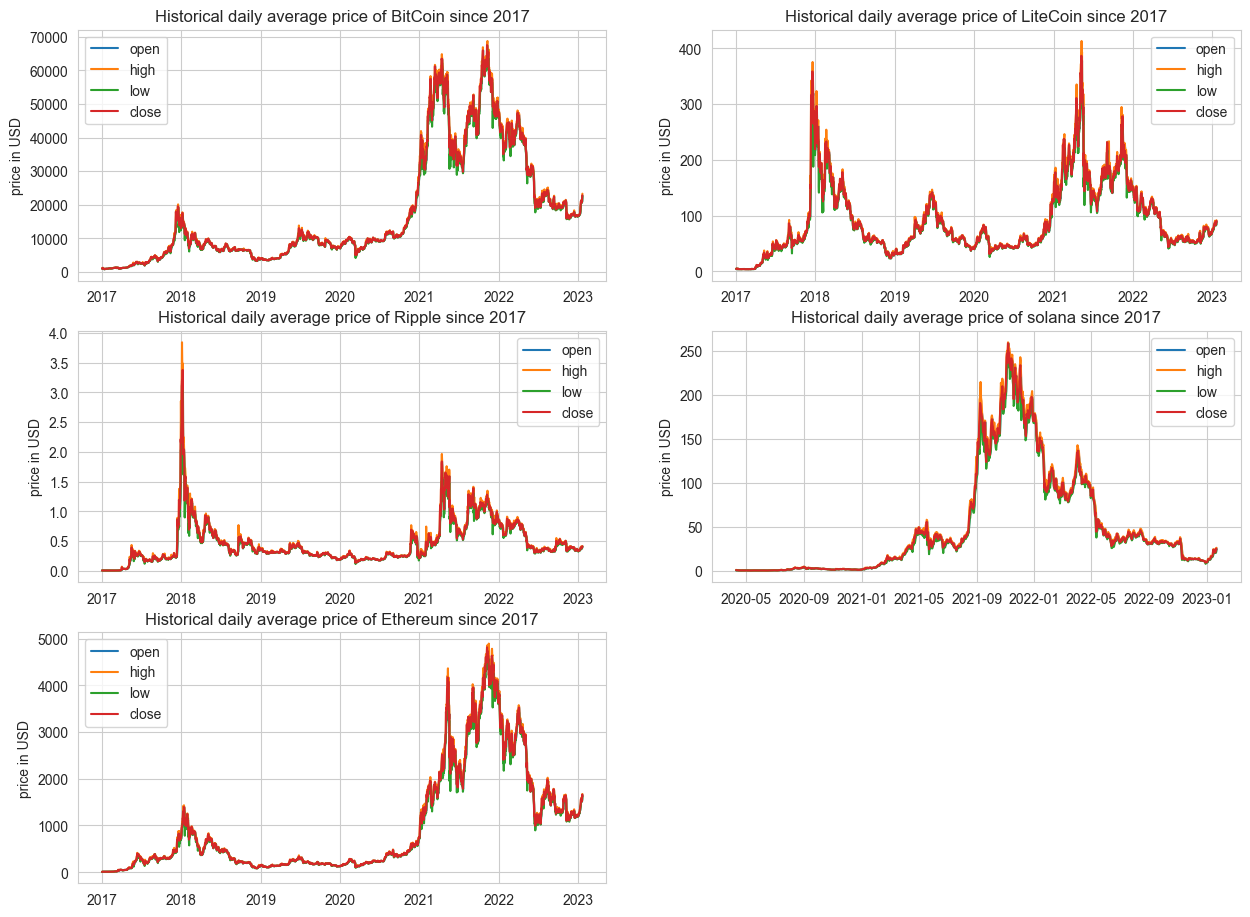

In [219]:
plt.figure(figsize=(15, 15))
plt.subplot(4,2,1)
plt.plot(bitcoin[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,2)
plt.plot(litecoin[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of LiteCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,3)
plt.plot(ripple[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ripple since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,4)
plt.plot(solana[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of solana since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,5)
plt.plot(ethereum[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ethereum since 2017')
plt.legend(['open','high','low','close'])




plt.show()

Un grand nombre des graphes ci-dessus ne montrent pas beaucoup de différences entre les différents prix,
mais comme nous l'avons découvert précédemment à partir du volume des transactions et de l'évolution du prix moyen,
une tendance très évidente est que lorsque le prix ou le volume de Bitcoin augmente, le prix
et le volume des autres crypto-monnaies ont également augmenté.
 C'est probablement parce que le succès du Bitcoin ouvre la voie aux écosystèmes de cryptomonnaies et attire de plus en plus d'investisseurs.
 En outre, le prix d'achat élevé de Bitcoin pourrait déclencher des achats pour ses alternatives moins chères.

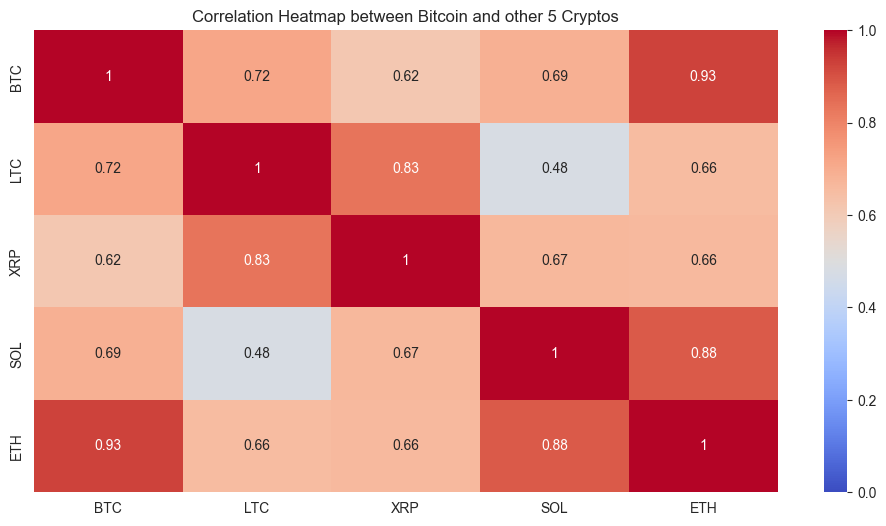

In [28]:
plt.figure(figsize=(12,6))
sns.heatmap(Close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other 5 Cryptos')
plt.show()

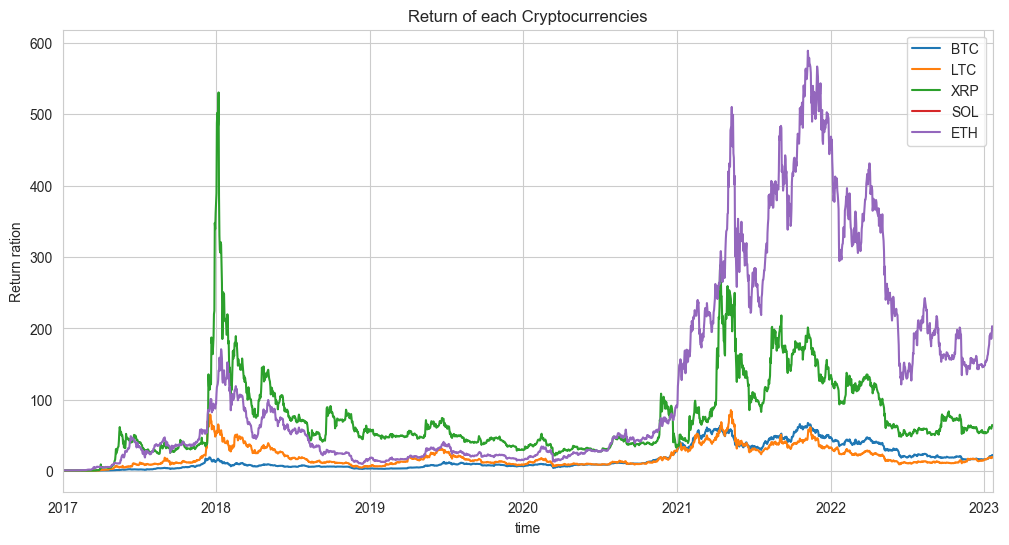

In [29]:
#return ratio = current value of the cryptocurrency / initial value of the cryptocurrency
returns = Close.apply(lambda x: x/x[0])
returns.plot(figsize=(12,6))
plt.ylabel('Return ration')
plt.xlabel('time')
plt.title('Return of each Cryptocurrencies')
plt.show()

#Il semble que depuis 2017, Ripple (XRP) et Ethereum (ETH) aient le taux de rendement le plus élevé, tandis que le reste des crypto-monnaies reste assez stable.

#Investir dans Ripple et Ethereum pourrait obtenir de meilleurs rendements mais depuis 2022, la tendance est à la baisse.

#Investir dans des crypto-monnaies populaires comme BitCoin et LiteCoin pourrait encore valoir la peine d'essayer car leur prix est assez stable et il semble y avoir une tendance à la hausse.



In [30]:
data_split =data.copy()


Bitcoin.

Depuis le lancement de Bitcoin en 2008, des centaines de projets similaires basés sur la technologie blockchain ont vu le jour. Nous appelons ces crypto-monnaies (également des pièces ou des cryptos dans l'argot Internet). Certaines sont extrêmement précieuses de nos jours, et d'autres pourraient devenir extrêmement précieuses à l'avenir.
En fait, le 6 décembre 2017, Bitcoin a une capitalisation boursière supérieure à 200 milliards de dollars.


L'augmentation étonnante de la capitalisation boursière de BitCoin en 2017.

*- AVERTISSEMENT : Le marché des crypto-monnaies est exceptionnellement volatil et tout argent que vous y investissez peut disparaître dans les airs. certaine crypto-monnaies peuvent être des escroqueries similaires aux schémas de Ponzi ou avoir de nombreux autres problèmes (surévaluation, technique, etc.). S'il vous plaît ne confondez pas cela avec des conseils d'investissement. *

Cela dit, nous allons nous interessé dans la suite de ce projet uniquement au Bitcoin 

<AxesSubplot:xlabel='slug', ylabel='Market Cap'>

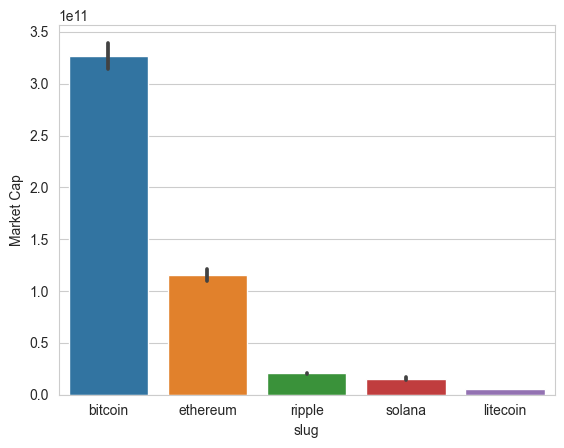

In [31]:

sns.barplot(y="Market Cap",x="slug",data=data)

In [32]:
data_split= data_split.sort_index()

In [33]:
coin="BTC"

date_specified = data_split.loc["2021-10-10":"2023-1-17"]
date_specified_coin = date_specified[date_specified["symbol"]==coin]

In [34]:
date_specified_coin.head()

,slug,symbol,Open,High,Low,Close,Volume,Market Cap,oc_diff,daily_avg
2021-10-10,bitcoin,BTC,54952.821251,56401.304241,54264.256389,54771.579184,3.952779e+10,1.031910e+12,-181.242067,55097.490266
2021-10-11,bitcoin,BTC,54734.124841,57793.039249,54519.765520,57484.789465,4.263733e+10,1.083079e+12,2750.664625,56132.929769
2021-10-12,bitcoin,BTC,57526.832011,57627.878602,54477.974468,56041.056838,4.108376e+10,1.055926e+12,-1485.775173,56418.435480
2021-10-13,bitcoin,BTC,56038.256788,57688.660104,54370.973228,57401.097527,4.168425e+10,1.081612e+12,1362.840739,56374.746912
2021-10-14,bitcoin,BTC,57372.832079,58478.735499,56957.076136,57321.525280,3.661579e+10,1.080160e+12,-51.306799,57532.542248


Voici le graphique mettant en évidence le prix de clôture de l'actif :

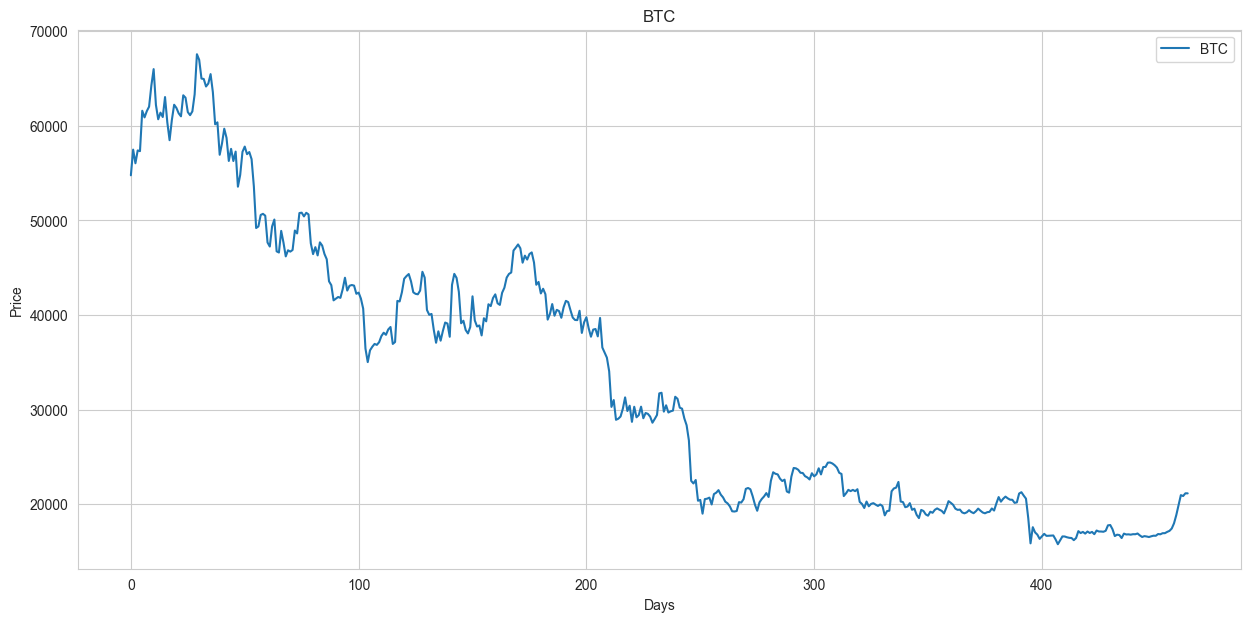

In [36]:
# Plot the close price data
series = date_specified_coin['Close']
series.index = np.arange(series.shape[0])

plt.figure(figsize=(15, 7))
plt.title("BTC")

plt.xlabel('Days')
plt.ylabel('Price')

plt.plot(series, label="BTC")

plt.legend()
plt.show()


Maintenant que nous avons toutes nos données en place, la prochaine étape consiste à identifier les hauts et les bas  dans le graphique de prix ci-dessus. Une façon plus simple de le faire est d'identifier les points de minima locaux et de maxima locaux.


Pour identifier les points minima et maxima locaux, nous devrons d'abord lisser le graphique des prix. Ceci peut être réalisé en utilisant la fonction savgol.filter de la bibliothèque scipy.signal.

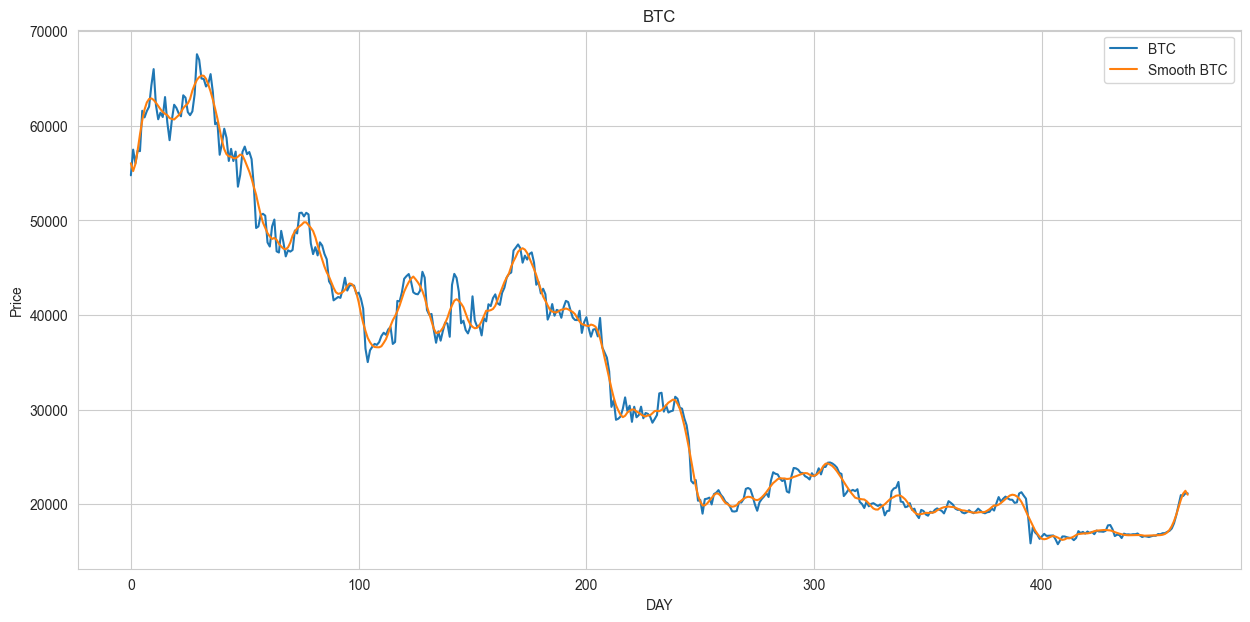

In [37]:


# To find amount of data in months
month_diff = series.shape[0] // 30
# We need value to be greater than 0
if month_diff == 0:
    month_diff = 1

# Algo to determine smoothness
smooth = int(2 * month_diff + 3)

# Smooth price data
points = savgol_filter(series, smooth, 7)

# Plot the smooth price graph over default price graph
plt.figure(figsize=(15,7))
plt.title("BTC")

plt.xlabel('DAY')
plt.ylabel('Price')

# Close price data
plt.plot(series, label="BTC")

# Smooth close price data
plt.plot(points, label=f'Smooth {"BTC"}')

plt.legend()
plt.show()

Ensuite, nous tracerons et comparerons le graphique de prix de clôture normal avec le graphique de prix de clôture lissé.


Pour identifier les points minima locaux et maxima locaux, nous avons créé deux fonctions à savoir : la fonction pythg() et la fonction loc_min_max().

In [38]:

# Pythagoras function to calculate distance between two points
def pythg(pt1, pt2):
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    return sqrt(a_sq + b_sq)


# Function to calculate local minima and maxima points
def loc_min_max(points):
    loc_minima = []
    loc_maxima = []
    prev_pts = [(0, points[0]), (1, points[1])]
    for i in range(1, len(points) - 1):
        append_to = ''
        if points[i-1] > points[i] < points[i+1]:
            append_to = 'min'
        elif points[i-1] < points[i] > points[i+1]:
            append_to = 'max'
        if append_to:
            if loc_minima or loc_maxima:
                prev_distance = pythg(prev_pts[0], prev_pts[1]) * 0.5
                curr_distance = pythg(prev_pts[1], (i, points[i]))
                if curr_distance >= prev_distance:
                    prev_pts[0] = prev_pts[1]
                    prev_pts[1] = (i, points[i])
                    if append_to == 'min':
                        loc_minima.append((i, points[i]))
                    else:
                        loc_maxima.append((i, points[i]))
            else:
                prev_pts[0] = prev_pts[1]
                prev_pts[1] = (i, points[i])
                if append_to == 'min':
                    loc_minima.append((i, points[i]))
                else:
                    loc_maxima.append((i, points[i]))
                    
    return loc_minima, loc_maxima

# Store the local minima and maxima points
loc_minima, loc_maxima = loc_min_max(points)
minima_pts = np.array(loc_minima)
maxima_pts = np.array(loc_maxima)

La fonction loc_min_max() boucle sur tous les points allant de l'indice 1 à -1.

Si un point donné est plus petit que le point précédent et le point suivant, il s'agit d'un minimum local. De même, si un point est supérieur au point précédent et au point suivant, il est appelé maximum local.

Vous remarquerez que nous pouvons avoir de nombreux minima locaux et maxima locaux si nous suivons la logique ci-dessus. Pour éviter de rencontrer ce problème, nous avons défini la fonction pythg(). Nous utilisons la fonction pythg() pour calculer la distance entre le point actuel et le point précédent ainsi que la distance entre le point actuel et le point suivant.

Nous sélectionnons un point comme minima local ou maxima local uniquement si la distance entre le point actuel et le point suivant est supérieure à la moitié de la distance entre les points actuel et précédent.

Ce qui suit est le résultat tracé des points minima et maxima locaux calculés à l'aide des fonctions ci-dessus.

Ensuite, nous définirons une fonction appelée line_mse() qui calcule l'erreur quadratique moyenne de chaque ligne.

In [39]:
# The line_mse() function computes and returns the mean squared error for
# the distance of all points from the line passing through points pt1 and pt2.

norm = np.linalg.norm

# Function takes two points pt1, pt2 and the minima/maxima dataset as input.
def line_mse(pt1, pt2, data):
    dist = 0
    dist_sq = 0
    sum_dist_sq = 0
    mean_sq_err = 0
    length = len(data)

    for pt3 in range(0, length):
            p1 = data[pt1]
            p2 = data[pt2]
            p3 = data[pt3]           
            
            # To calculate perpendicular distance of a point from line passing through pt1 and pt2
            dist = np.abs(norm(np.cross(p2-p1, p1-p3)))/norm(p2-p1)            
            # Squared error of a point from line passing through pt1 and pt2
            dist_sq = dist**2
            # Sum of squared errors of all points from line passing through pt1 and pt2
            sum_dist_sq = sum_dist_sq + dist_sq
            
    # Mean squared error formula applied
    mean_sq_err = sum_dist_sq / length
    return (mean_sq_err)

La valeur d'erreur quadratique moyenne nous aide à évaluer l'écart global de tous les points présents dans l'ensemble de données minima_pts ou maxima_pts par rapport à la ligne de support ou de résistance identifiée.

Dans la prochaine étape, nous essaierons d'identifier toutes les lignes de support et de résistance potentielles.

Une ligne de support potentielle serait une ligne qui relie deux bas de swing ou plus (points minima locaux) tandis qu'une ligne de résistance potentielle serait toute ligne qui relie deux hauts ou plus (points maxima locaux)

Nous utiliserons la fonction s_r_lines() pour récupérer les coordonnées de toutes les lignes possibles passant par au moins deux points connus à partir de nos ensembles de données minima_pts et maxima_pts respectivement.

In [40]:
# The s_r_lines() function identifies and returns all potential support and 
# resistance line coordinates along with its corresponding mean squared error value.

def s_r_lines(data):
    lines = []
    for pt1 in range(0, len(data) - 1):
        for pt2 in range(0, len(data)):
            if pt1 != pt2:
                mse_val = line_mse(pt1, pt2, data)
                lines.append((data[pt1], data[pt2], mse_val))
    return lines

# Compute and store data of potential support and resistance lines
support_lines = s_r_lines(minima_pts)
resistance_lines = s_r_lines(maxima_pts)

Les coordonnées et la valeur MSE de toutes les lignes de support potentielles sont enregistrées dans le tableau support_lines. De même, les valeurs des lignes de résistance potentielles sont enregistrées dans le tableau nommé resistance_lines.

Ensuite, nous utiliserons la fonction line_least_mse() pour parcourir toutes les données présentes respectivement dans les tableaux support_lines et resistance_lines et récupérer la ligne qui a la plus petite valeur MSE.

In [41]:
# The 'line_least_mse()' function returns data for the 
# line which has the least mean squared error value.

def line_least_mse(data):
    best_line = []
    # Temporarily assign value of first line in dataset as 'least_mse'
    least_mse = data[0][2]
    
    # Compare MSE values of all lines present in the dataset
    for r in range (0, len(data)):
            if data[r][2] < least_mse:
                
                # Assign the current value to 'least_mse' if 
                # the current value is less than existing value
                least_mse = data[r][2]
                
                # Store data of the line with least mse value
                best_line = data[r]
                
    return best_line

# Support and resistance lines having least MSE value
support = line_least_mse(support_lines)
resistance = line_least_mse(resistance_lines)

Les données correspondant aux meilleures lignes de support et de résistance sont affichées ci-dessous

In [42]:
support
# Values are in the format: Pt1(x1,y1), Pt2(x2,y2), MSE Value

(array([  134.        , 38109.15034452]),
 array([  251.        , 19888.70910759]),
 852.8977903406983)

In [43]:
resistance
# Values are in the format: Pt1(x1,y1), Pt2(x2,y2), MSE Value

(array([9.0000000e+00, 6.2899746e+04]),
 array([  156.        , 40460.15396811]),
 721.1810115869962)

In [44]:
# Assign the x and y co-ordinates

# For the support line
s_x1 = support[0][0]
s_x2 = support[1][0]
s_y1 = support[0][1]
s_y2 = support[1][1]

# For the resistance line
r_x1 = resistance[0][0]
r_x2 = resistance[1][0]
r_y1 = resistance[0][1]
r_y2 = resistance[1][1]

Lastly, we will plot the support and resistance lines on the asset’s close price graph.


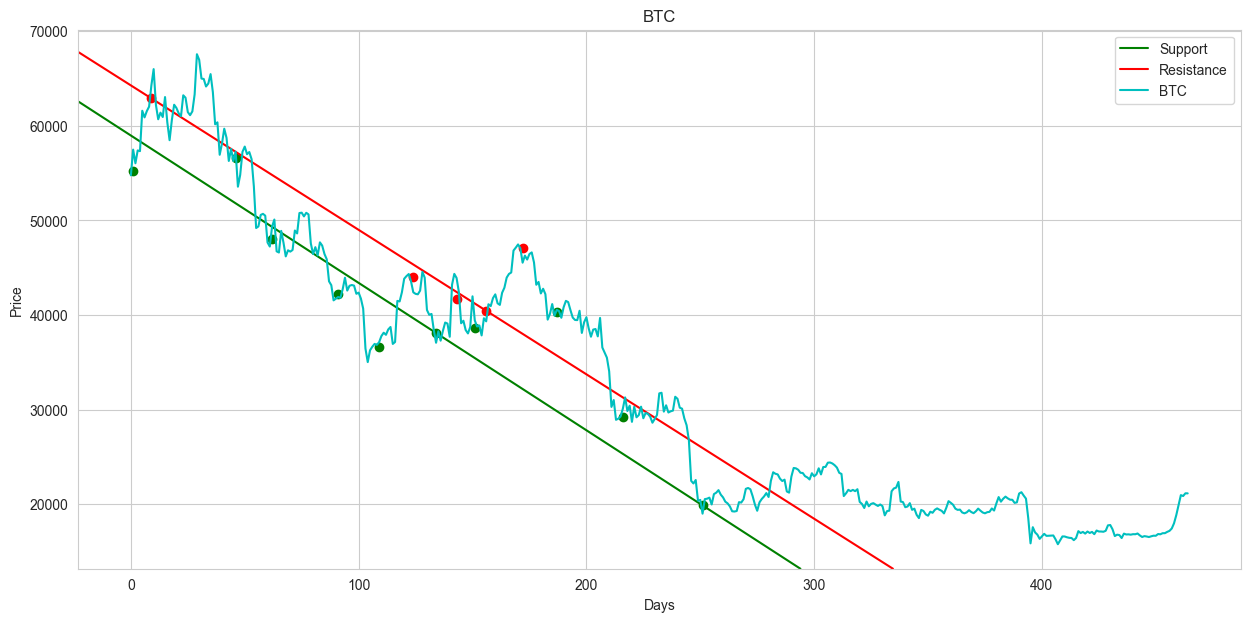

In [45]:
plt.figure(figsize=(15,7))

plt.title("BTC")
plt.xlabel('Days')
plt.ylabel('Price')

# Support line
plt.axline((s_x1,s_y1), (s_x2,s_y2), label='Support', c='g')

# Resistance line
plt.axline((r_x1,r_y1), (r_x2,r_y2), label='Resistance', c='r')

# Close price data
plt.plot(series, label="BTC", c='c')

for pt in loc_minima:
    plt.scatter(pt[0], pt[1], c='g')
for pt in loc_maxima:
    plt.scatter(pt[0], pt[1], c='r')
    
plt.legend()
plt.show()

 Le marché des cryptos a vécu une année 2022 particulièrement compliquée. La plupart des cryptomonnaies sont en baisse depuis plusieurs mois déjà. Le cours du Bitcoin, par exemple, a perdu environ 60 % de sa valeur depuis le début de l'année et se situe actuellement aux alentours de 17 000 dollars US.

# Monte Carlo Simulation

# Qu'est-ce qu'une simulation de Monte-Carlo ?

Il s'agit d'une technique utilisée pour comprendre l'impact du risque et de l'incertitude dans les modèles de prédiction et de prévision. Le modèle est très utile pour évaluer le risque associé à l'actif, car il produit des résultats et des possibilités extrêmes, et il peut vous donner une idée de l'orientation potentielle du prix de l'actif à l'avenir.

Dans cet exemple, je vais créer une simulation de 400 résultats futurs potentiels pour l'évolution du prix de Bitcoin pour les 100 prochains jours.

In [46]:
BTC_df_close=date_specified_coin.filter(['Close'])

In [47]:

returns = BTC_df_close.pct_change()
meanReturns = returns.mean()
covMatrix = returns.cov()


In [48]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

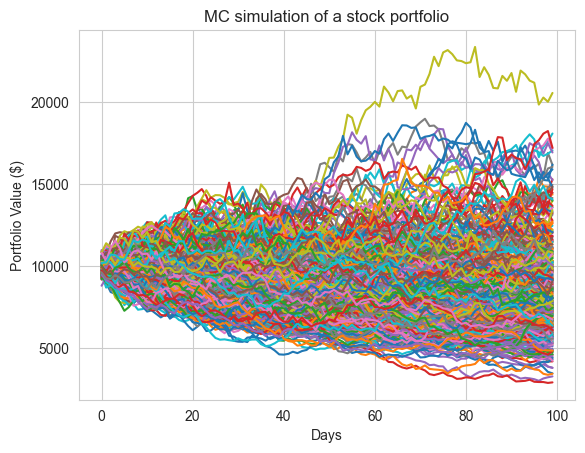

In [49]:
mc_sims = 400 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [50]:
date_specified_coin.index.names = ['Date']
date_specified_coin.reset_index()


,Date,slug,symbol,Open,High,Low,Close,Volume,Market Cap,oc_diff,daily_avg
0,2021-10-10,bitcoin,BTC,54952.821251,56401.304241,54264.256389,54771.579184,3.952779e+10,1.031910e+12,-181.242067,55097.490266
1,2021-10-11,bitcoin,BTC,54734.124841,57793.039249,54519.765520,57484.789465,4.263733e+10,1.083079e+12,2750.664625,56132.929769
2,2021-10-12,bitcoin,BTC,57526.832011,57627.878602,54477.974468,56041.056838,4.108376e+10,1.055926e+12,-1485.775173,56418.435480
3,2021-10-13,bitcoin,BTC,56038.256788,57688.660104,54370.973228,57401.097527,4.168425e+10,1.081612e+12,1362.840739,56374.746912
4,2021-10-14,bitcoin,BTC,57372.832079,58478.735499,56957.076136,57321.525280,3.661579e+10,1.080160e+12,-51.306799,57532.542248
...,...,...,...,...,...,...,...,...,...,...,...
460,2023-01-13,bitcoin,BTC,18868.905938,19964.322728,18753.164262,19909.574625,2.922503e+10,3.834832e+11,1040.668687,19373.991888
461,2023-01-14,bitcoin,BTC,19910.536657,21075.141830,19907.828464,20976.299796,3.896778e+10,4.040522e+11,1065.763139,20467.451687
462,2023-01-15,bitcoin,BTC,20977.484195,20993.748696,20606.987238,20880.799202,1.929841e+10,4.022347e+11,-96.684993,20864.754833
463,2023-01-16,bitcoin,BTC,20882.223877,21360.874279,20715.746214,21169.632781,2.679249e+10,4.078182e+11,287.408904,21032.119288


# Prediction using Machine learning 

In [51]:
BTC= date_specified_coin.copy()

In [52]:
BTC=BTC.drop(['slug'], axis=1)

In [53]:
coins=""
kwargs = {'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
        'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
BTC = BTC.assign(**kwargs)

In [54]:
BTC['daily_avg_After_Month']=BTC['daily_avg'].shift(-30)
BTC = BTC.sort_index()
X_BTC = BTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_BTC = BTC.dropna()['daily_avg_After_Month']

X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC = train_test_split(X_BTC, y_BTC, test_size=0.2, random_state=43)
X_forecast_BTC =  BTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

In [55]:
BTC = BTC.dropna()
y_BTC

Date
2021-10-10    67358.491093
2021-10-11    65986.577425
2021-10-12    64922.088975
2021-10-13    64203.662568
2021-10-14    64211.765101
                  ...     
2022-12-14    19373.991888
2022-12-15    20467.451687
2022-12-16    20864.754833
2022-12-17    21032.119288
2022-12-18    21188.636366
Name: daily_avg_After_Month, Length: 435, dtype: float64

In [229]:
# define regression function
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=500, min_samples_split=5),
        
        
    }

    for name, clf in Regressor.items():
        print(name)
        clf.fit(X_train, y_train)
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):.2f}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):.2f}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):.2f}')
        print()
     

In [230]:
# Bitcoin (BTC)
print('Bitcoin (BTC):')
regression(X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC)


Bitcoin (BTC):
Random Forest Regressor
R2: 0.93
MAE: 2534.95
MSE: 12255747.61

ExtraTrees Regressor
R2: 0.94
MAE: 2350.13
MSE: 10096123.59



In [58]:
# Liste des algorithmes à entraîner

seed = 123

models = []

models.append(('LR', {'model':LinearRegression()}))
models.append(('LASSO', {'model':Lasso()}))
models.append(('EN', {'model':ElasticNet()}))
models.append(('KNN', {'model':KNeighborsRegressor()}))
models.append(('CART', {'model':DecisionTreeRegressor(random_state = seed)}))
models.append(('SVR', {'model':SVR()}))

models.append(('ABR', {'model':AdaBoostRegressor(random_state = seed)}))
models.append(('XGBOOST', {'model':XGBRegressor(random_state=seed)}))
models.append(('GBR', {'model':GradientBoostingRegressor(random_state = seed)}))

models.append(('RFR', {'model':RandomForestRegressor(random_state = seed)}))
models.append(('ETR', {'model':ExtraTreesRegressor(random_state = seed)}))

algos_ml = dict(models)

num_folds = 5
scoring = 'neg_mean_squared_error'
kfold_results = []

for model_name in algos_ml.keys():
    
   
    
    fitted_model = algos_ml[model_name]['model'].fit(X_train_BTC, y_train_BTC)
    algos_ml[model_name]['RMSE test'] = np.sqrt(mean_squared_error(y_test_BTC, fitted_model.predict(X_test_BTC)))
    algos_ml[model_name]['R² test'] = r2_score(y_test_BTC, fitted_model.predict(X_test_BTC))
    
    
# Meilleur affichage sous forme de tableau

results_metrics = pd.DataFrame.from_dict(
    algos_ml, 
    'index')[[ 'RMSE test','R² test']]

with pd.option_context('display.precision', 3):
    best_print = results_metrics.sort_values(by='RMSE test', ascending=True)

best_print

,RMSE test,R² test
ETR,3133.506597,0.943573
RFR,3337.872802,0.935973
KNN,3483.652680,0.930258
ABR,3566.946160,0.926883
GBR,3666.248563,0.922756
LR,3917.677846,0.911798
XGBOOST,4086.594143,0.904028
LASSO,4347.995286,0.891357
EN,4391.728714,0.889161
CART,4750.106293,0.870333


In [59]:
# define prediction function
def prediction(name, X, y, X_forecast):
    if name in ['BTC']:
        model = RandomForestRegressor(n_estimators=200)
    else:
        model = ExtraTreesRegressor(n_estimators=500, min_samples_split=5)
    model.fit(X, y)
    target = model.predict(X_forecast)
    return target

In [60]:
forecasted_BTC_RF = prediction('BTC', X_BTC, y_BTC, X_forecast_BTC)
forecasted_BTC_XGB = algos_ml["GBR"]['model'].predict(X_forecast_BTC)
# forecasted_BTC_copy = forecasted_BTC.copy()
# forecasted_BTC_copy["daily_avg"] = forecasted_BTC_XGB
# forecasted_BTC_XGB = forecasted_BTC_copy

In [61]:
# define index for next 30 days
last_date=BTC.iloc[-1].name
modified_date = last_date + timedelta(days=1)
new_date = pd.date_range(modified_date,periods=30,freq='D')

# assign prediction to newly defined index
forecasted_BTC_XGB = pd.DataFrame(forecasted_BTC_XGB, columns=['daily_avg'], index=new_date)

# # combine historical price and predicted price
bitcoin = pd.concat([BTC[BTC['symbol']=='BTC'][['daily_avg']], forecasted_BTC_XGB])
# # datetime.timedelta(days=1)

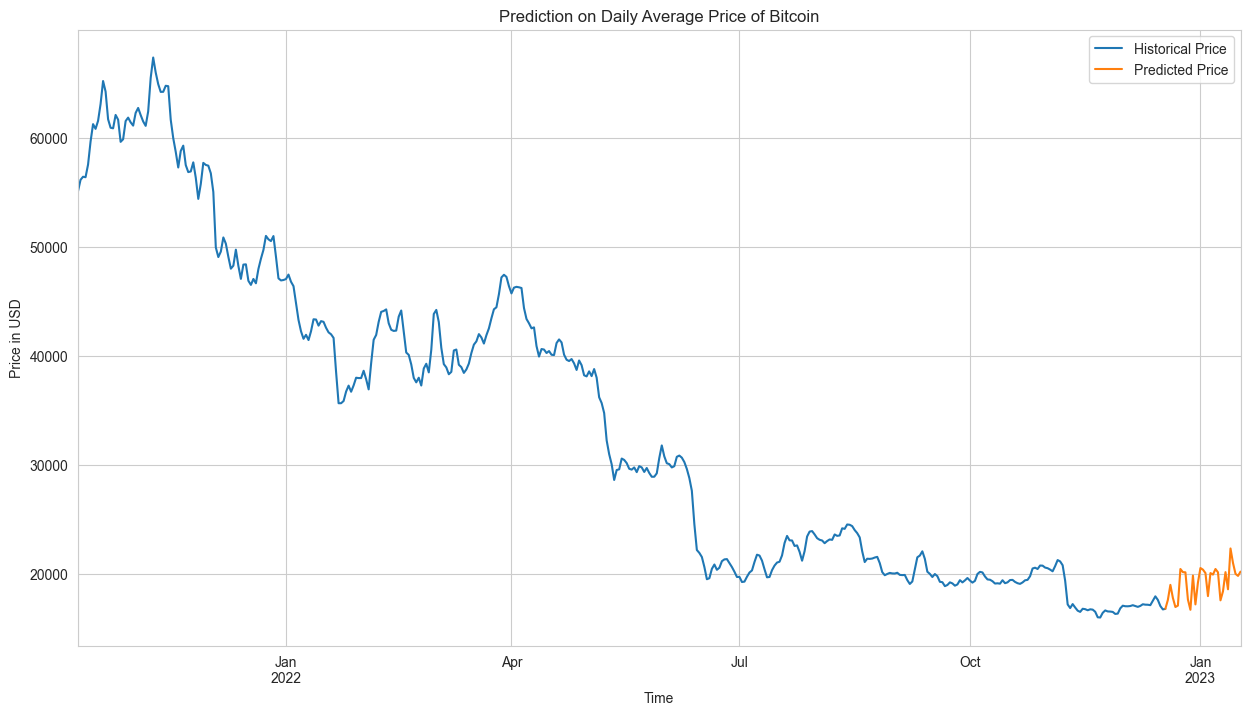

In [62]:
plt.figure(figsize=(15,8))
(bitcoin[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()

In [63]:
# define index for next 30 days
last_date=BTC.iloc[-1].name
modified_date = last_date + timedelta(days=1)
new_date = pd.date_range(modified_date,periods=30,freq='D')

# assign prediction to newly defined index
forecasted_BTC_RF = pd.DataFrame(forecasted_BTC_RF, columns=['daily_avg'], index=new_date)

# # combine historical price and predicted price
bitcoin = pd.concat([BTC[BTC['symbol']=='BTC'][['daily_avg']], forecasted_BTC_RF])
# # datetime.timedelta(days=1)

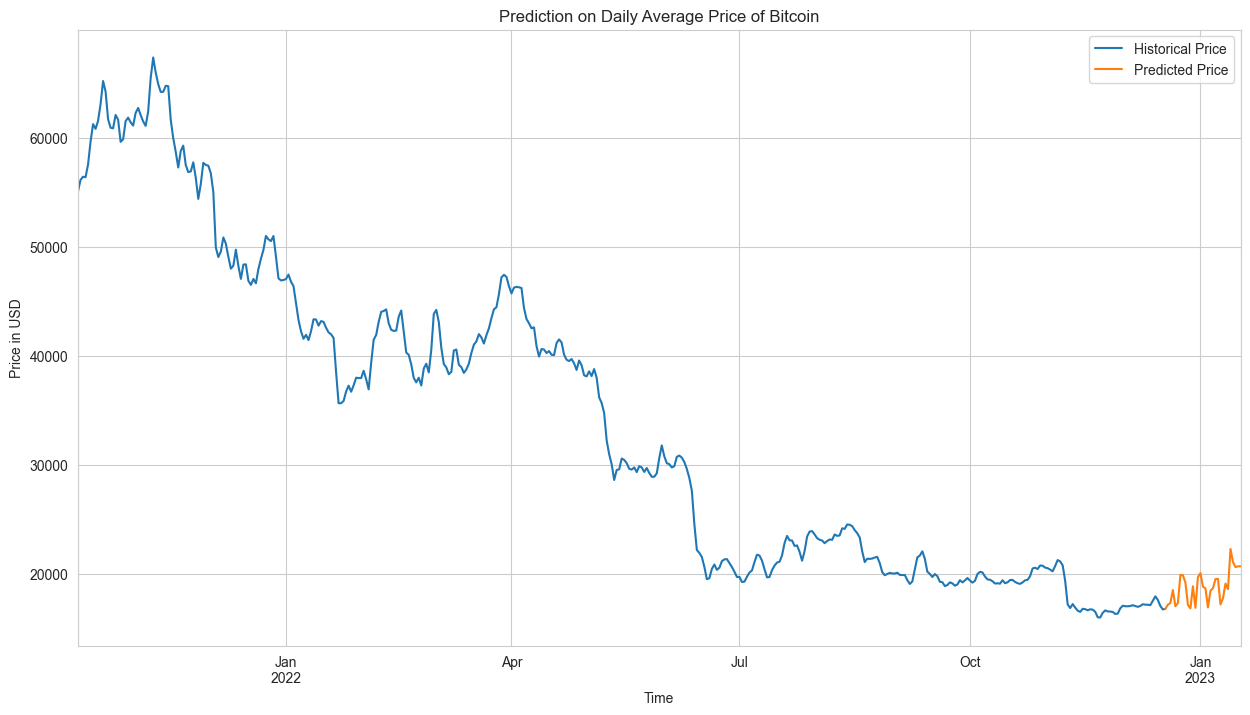

In [64]:
plt.figure(figsize=(15,8))
(bitcoin[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()

# prediction using facebook prophet

In [66]:
df1 = date_specified_coin.copy()

In [67]:
df1 =  df1.reset_index()
df1 = df1.sort_values(by='Date')

In [68]:
df2 = df1[['Date','Close']]

In [69]:
df2

,Date,Close
0,2021-10-10,54771.579184
1,2021-10-11,57484.789465
2,2021-10-12,56041.056838
3,2021-10-13,57401.097527
4,2021-10-14,57321.525280
...,...,...
460,2023-01-13,19909.574625
461,2023-01-14,20976.299796
462,2023-01-15,20880.799202
463,2023-01-16,21169.632781


Facebook Prophet n'accepte que deux colonnes ds et y. Nous avons juste besoin de renommer la colonne Date en ds et la colonne Close en y.

In [70]:
#rename columns
prophet_df = df2.rename(columns={'Date':'ds',
                                'Close':'y'})

#check
prophet_df.columns

Index(['ds', 'y'], dtype='object')

C'est tout le prétraitement que nous devons faire. Il ne nous reste plus qu'à initialiser en appelant Prophet() et à ajuster le modèle avec prophet_df.

In [71]:
#initialize
model = Prophet()

#fit
model.fit(prophet_df)

20:27:28 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] done processing


Prévision à l'aide de Facebook Prophet

Nous allons utiliser le modèle Facebook Prophet pour prévoir 30 jours dans le futur. Nous pouvons simplement attribuer le nombre de périodes que nous voulons voir dans le futur. Comme nous avons des données historiques quotidiennes, nous devons attribuer un nombre de période qui serait équivalent à quotidiennement. Donc, pendant 120 jours, il doit être périodes = 120.

In [72]:
#forecast for the next 120 days
future = model.make_future_dataframe(periods=120)

#predict
forecast = model.predict(future)

In [73]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          585 non-null    datetime64[ns]
 1   trend                       585 non-null    float64       
 2   yhat_lower                  585 non-null    float64       
 3   yhat_upper                  585 non-null    float64       
 4   trend_lower                 585 non-null    float64       
 5   trend_upper                 585 non-null    float64       
 6   additive_terms              585 non-null    float64       
 7   additive_terms_lower        585 non-null    float64       
 8   additive_terms_upper        585 non-null    float64       
 9   weekly                      585 non-null    float64       
 10  weekly_lower                585 non-null    float64       
 11  weekly_upper                585 non-null    float64       

Comme vous pouvez le voir, nous obtenons une donnée qui a 19 colonnes :


Nos données vont du 2021 au 2023, ce qui signifie que les nouveaux 120 jours ont été ajoutés à nos données.

yhat_upper : limite supérieure

yhat_lower : limite inférieure

yhat : valeur prédite

Prophet dispose d'outils de visualisation internes qui nous aideraient à visualiser les prévisions en transmettant la nouvelle trame de données de prévision :



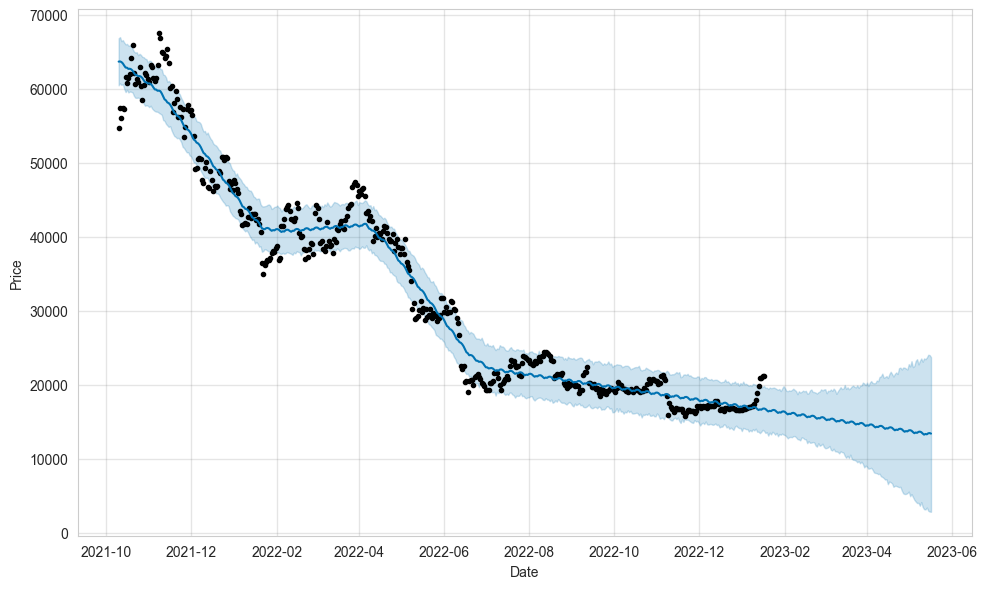

In [74]:

#visualize with Facebook internal tool
figure_1 = model.plot(forecast,
                    xlabel='Date',
                    ylabel='Price')

La ligne noire représente les données réelles

La ligne bleue est la valeur prédite

La zone ombragée est la limite supérieure et la limite inférieure.

Visualisons maintenant les tendances avec la fonction plot_component :

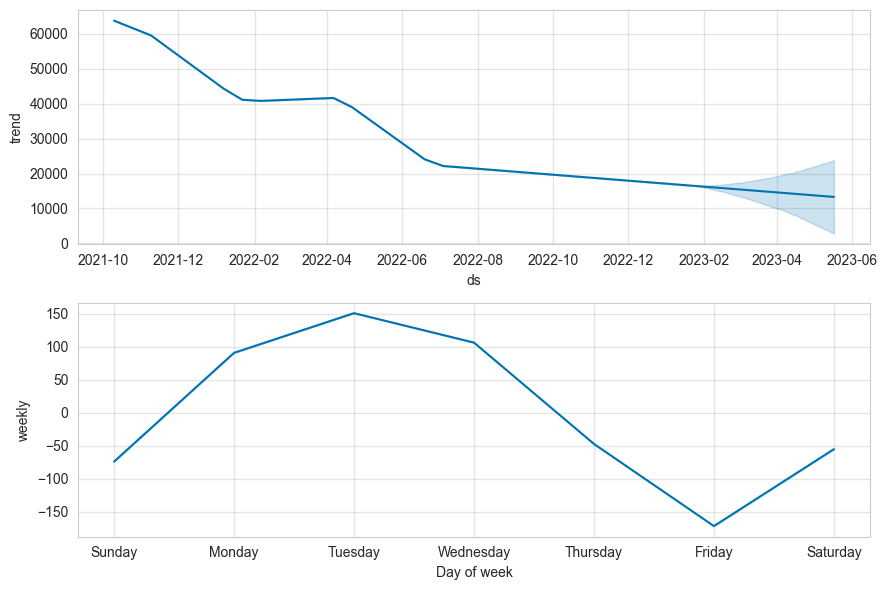

In [75]:
#visualize forecast
figure_2 = model.plot_components(forecast)

In [76]:
metric_df = forecast.set_index('ds')[['yhat']].join(prophet_df.set_index('ds').y).reset_index()

In [77]:
metric_df.tail()

,ds,yhat,y
580,2023-05-13,13355.364303,NaN
581,2023-05-14,13308.477500,NaN
582,2023-05-15,13445.249326,NaN
583,2023-05-16,13477.409900,NaN
584,2023-05-17,13404.851710,NaN


In [78]:
metric_df.dropna(inplace=True)

In [79]:
metric_df.tail()

,ds,yhat,y
460,2023-01-13,16594.514642,19909.574625
461,2023-01-14,16683.071863,20976.299796
462,2023-01-15,16636.185060,20880.799202
463,2023-01-16,16772.956886,21169.632781
464,2023-01-17,16805.117460,21161.519220


In [80]:
r2_score(metric_df.y, metric_df.yhat)

0.9730347338229866

In [81]:
mean_squared_error(metric_df.y, metric_df.yhat)

5717945.398797496

In [82]:
mean_absolute_error(metric_df.y, metric_df.yhat)

1849.4593796210502

# Prediction using LSTM

La prochaine étape du processus vient de la partie où nous pouvons commencer à construire le modèle LSTM pour la prévision des prix de clôture. Puisque nous voulons prédire le cours de clôture, nous allons créer une nouvelle trame de données pour n'inclure que ces données d'intérêt pour notre modèle.


In [186]:
df = date_specified_coin.copy()

In [187]:
df =  df.reset_index()
df = df.sort_values(by='Date')

In [188]:
model_data = df[['Date','Close']]


Prétraitement des données

La prochaine étape serait de normaliser le cours de clôture entre 0 et 1 dans notre ensemble de données. Ceci est important pour changer les valeurs des prix de clôture à une échelle commune sans fausser les différences dans les plages de valeurs.

In [189]:
del model_data['Date']
scaler = MinMaxScaler(feature_range=(0,1))
close_df = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
close_df

Divisions d'entraînement et de test

L'étape suivante consisterait à partitionner la trame de données en une division d'apprentissage et de test. Puisque nous disposons de données adéquates, utilisons un ratio de partage de formation et de test de 90/10.

In [191]:
training_size = int(len(close_df)*0.9)
test_size = len(close_df)-training_size
train_data,test_data = close_df[0:training_size,:],close_df[training_size:len(close_df),:1]
print('train_data: ', train_data.shape)
print('test_data: ', test_data.shape)

train_data:  (418, 1)
test_data:  (47, 1)


La prochaine étape consisterait à transformer l'ensemble de données dans un format de série temporelle , y compris un pas de temps pour LSTM. Pour LSTM, le pas de temps représente le nombre ou la longueur des points de données précédents, y compris le point de données actuel pour la prédiction.

On peut d'abord définir une fonction pour ajouter un pas de temps en dessous.

In [192]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

Ensuite, nous appliquerons la fonction sur notre jeu de données, y compris le pas de temps défini.

In [193]:
time_step = 10 
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (407, 10, 1)
X_test:  (36, 10, 1)


Model Building

Next, we will start to define our LSTM model and the layers. Here we described ten hidden LSTM layers with a relu function (rectified linear unit activation function) and a Dense single layer.

The loss function computes the quantity that a model should seek to minimise during training (e.g. a lower MSE is preferred for regression problems in this example). Finally, the adam algorithm is used for optimisation.

More details on activations, losses or optimisation can be found here: Keras.

In [194]:
model = Sequential() 
# Adding a LSTM layer with 10 internal units
model.add(LSTM(10,input_shape=(None,1),activation='relu'))
# Adding a Dense layer with 1 units.
model.add(Dense(1))
# Loss function + optimizer
model.compile(loss='mean_squared_error',optimizer='adam')

Une fois le modèle, les couches, les couches d'activation, les fonctions de perte et les optimiseurs définis, nous pouvons former le modèle. Où les champs font référence aux éléments suivants :

époques = nombre de cycles pour former le réseau de neurones avec toutes les données de formation.

batch_size = nombre d'échantillons qui seront propagés sur le réseau. Par exemple, un batch_size de 100 signifierait que le modèle utiliserait les 100 premiers points de données de formation pour former le modèle, suivis des 100 suivants jusqu'à ce que toutes les données de formation soient utilisées.

verbeux = détail des résultats pour chaque processus de formation. (verbose=0 ne vous montrera rien (silencieux)

verbose=1 vous montrera une barre de progression animée et verbose=2 mentionnera le nombre d'époques)

In [226]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [195]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=10,verbose=1)

Epoch 1/100
41/41 [==============================] - 2s 10ms/step - loss: 0.1021 - val_loss: 0.0091
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0319
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0177
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 5/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 6/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 7/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 8/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 10/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 11

41/41 [==============================] - 0s 4ms/step - loss: 9.5671e-04 - val_loss: 2.4654e-04
Epoch 81/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 2.5574e-04
Epoch 82/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 2.7910e-04
Epoch 83/100
41/41 [==============================] - 0s 5ms/step - loss: 9.9565e-04 - val_loss: 2.5906e-04
Epoch 84/100
41/41 [==============================] - 0s 5ms/step - loss: 9.8157e-04 - val_loss: 3.2378e-04
Epoch 85/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 2.5003e-04
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 2.4092e-04
Epoch 87/100
41/41 [==============================] - 0s 5ms/step - loss: 9.2184e-04 - val_loss: 2.3924e-04
Epoch 88/100
41/41 [==============================] - 0s 5ms/step - loss: 9.4328e-04 - val_loss: 2.4585e-04
Epoch 89/100
41/41 [==============================] - 0s 

Nous pouvons alors comparer la validation le training loss où :

Validation loss indique dans quelle mesure le modèle s'adapte aux nouvelles données.

Training loss indique dans quelle mesure le modèle correspond aux données d'entraînement.

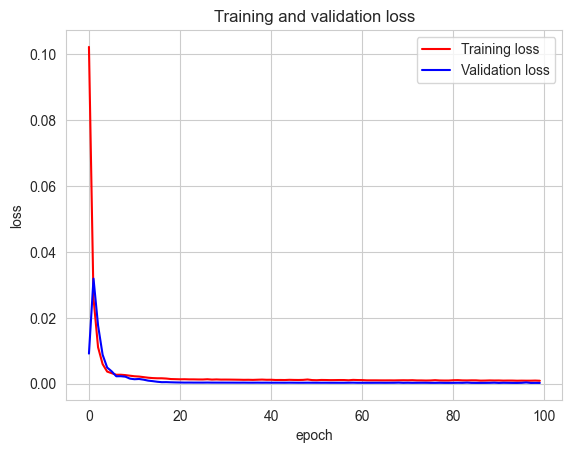

<Figure size 640x480 with 0 Axes>

In [220]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc=0)
plt.figure()
plt.show()

Prédiction du modèle

Enfin, nous pouvons prédire les cours de clôture à partir de notre modèle LSTM en utilisant les paramètres définis ci-dessus.

In [214]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
names = cycle(['Original close price','Train predicted close price','Test predicted close price'])
plotdf = pd.DataFrame({'date': df['Date'],
                       'original_close': df['Close'],
                      'train_predicted_close': scaler.inverse_transform(np.array(trainPredictPlot).reshape(-1,1)).reshape(1,-1).tolist()[0],
                      'test_predicted_close': scaler.inverse_transform(np.array(testPredictPlot).reshape(-1,1)).reshape(1,-1).tolist()[0]})
fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original vs predicted close price',
                  plot_bgcolor='white',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

2/2 [==============================] - 0s 3ms/step


Et si nous voulons utiliser le modèle pour les prévisions futures pour les 60 prochains jours.

In [215]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=time_step
i=0
pred_days = 60
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
temp_mat = np.empty(pred_days+1)
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]
next_predicted_days_value = temp_mat

next_predicted_days_value = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({
    'Predicted Close':next_predicted_days_value
})
names = cycle(['Predicted next 60 days close price'])
fig = px.line(new_pred_plot,x=new_pred_plot.index, y= new_pred_plot['Predicted Close'],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Next 60 days Closing price prediction',
                  plot_bgcolor='white',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Évaluation du modèle

Enfin, une étape importante lorsqu'il s'agit de modèles d'apprentissage automatique consiste à évaluer les performances de notre modèle. Cela permettra une comparaison avec d'autres modèles ou une référence si nous décidons d'ajuster le modèle.


In [216]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Comme il s'agit d'un problème de régression, nous utiliserons les mesures de performances suivantes.

In [221]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("-------------------------------------------------------------------------------------")

print("data R2 score:", r2_score(original_ytest, test_predict))

Train data RMSE:  1507.92804827045
Train data MSE:  2273846.9987607286
Train data MAE:  1066.5846486769449
-------------------------------------------------------------------------------------
Test data RMSE:  783.8748313881724
Test data MSE:  614459.7512838357
Test data MAE:  515.266603548685
-------------------------------------------------------------------------------------
data R2 score: 0.6222067486484143


C'est tout dans la construction et l'évaluation d'un modèle LSTM pour la prévision des prix Bitcoin. N'hésitez pas à expérimenter en modifiant les paramètres du modèle, en entraînant et en testant la partition fractionnée pour obtenir un modèle optimal avec des résultats prometteurs !

